# Injector Optimization with NN Prior at LCLS
Aiming to optimize transverse beam size with solenoid SQ, CQ and 6 Quads

In [1]:
n_threads = 6

In [2]:
import os
if n_threads is not None:
    os.environ["OMP_NUM_THREADS"] = str(n_threads)

In [3]:
# optionally add scripts location to path
if True:
    import sys
    sys.path.append("../../")
    sys.path.append("../")

run_dir = "/home/physics3/ml_tuning/20230825_LCLS_Injector/"
print(sys.path)

['/home/physics3/rroussel/SLAC_Xopt/lcls/nn_prior', '/usr/local/lcls/tools/python/toolbox', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python39.zip', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/lib-dynload', '', '/home/physics3/.local/lib/python3.9/site-packages', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages', '../../', '../']


## Set up image diagnostic

In [4]:
from scripts.image import ImageDiagnostic
import yaml

fname = "../OTR3_config.yml"
image_diagnostic = ImageDiagnostic.parse_obj(yaml.safe_load(open(fname)))
image_diagnostic.save_image_location = run_dir
image_diagnostic.n_fitting_restarts = 2
image_diagnostic.visualize = False
image_diagnostic.background_file = run_dir + "OTRS_IN20_621_background.npy"
print(image_diagnostic.yaml())

{screen_name: 'OTRS:IN20:621', array_data_suffix: IMAGE, array_n_cols_suffix: ROI_XNP,
  array_n_rows_suffix: ROI_YNP, resolution_suffix: RESOLUTION, resolution: 1.0, beam_shutter_pv: 'IOC:BSY0:MP01:MSHUTCTL',
  background_file: /home/physics3/ml_tuning/20230825_LCLS_Injector/OTRS_IN20_621_background.npy,
  save_image_location: /home/physics3/ml_tuning/20230825_LCLS_Injector/, roi: null,
  min_log_intensity: 4.0, bounding_box_half_width: 3.0, wait_time: 0.1, n_fitting_restarts: 2,
  visualize: false, return_statistics: false, threshold: 0.0, testing: false}



In [5]:
#image_diagnostic.measure_background(file_location=run_dir)

In [6]:
image_diagnostic.background_file

'/home/physics3/ml_tuning/20230825_LCLS_Injector/OTRS_IN20_621_background.npy'

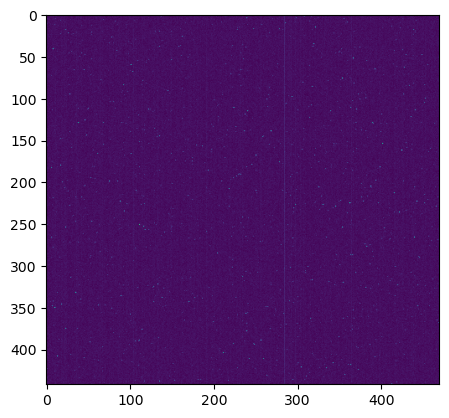

In [7]:
import matplotlib.pyplot as plt
plt.imshow(image_diagnostic.background_image)

{'Cx': nan,
 'Cy': 224.74138263669266,
 'Sx': nan,
 'Sy': 326.21165582258834,
 'bb_penalty': nan,
 'total_intensity': 461862.00000000006,
 'log10_total_intensity': 5.664512231852091}

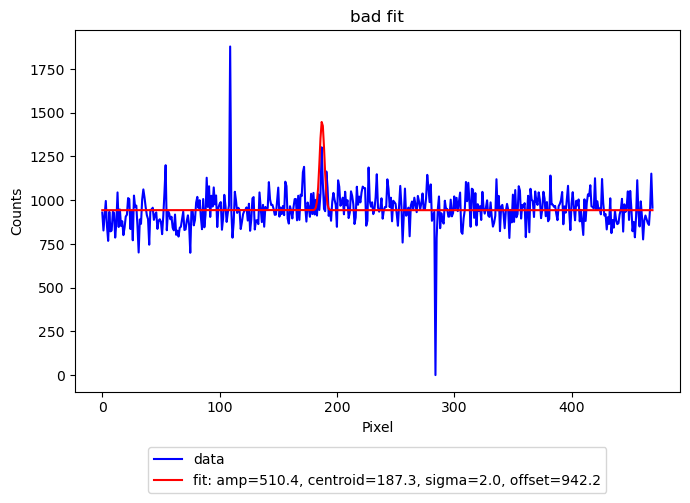

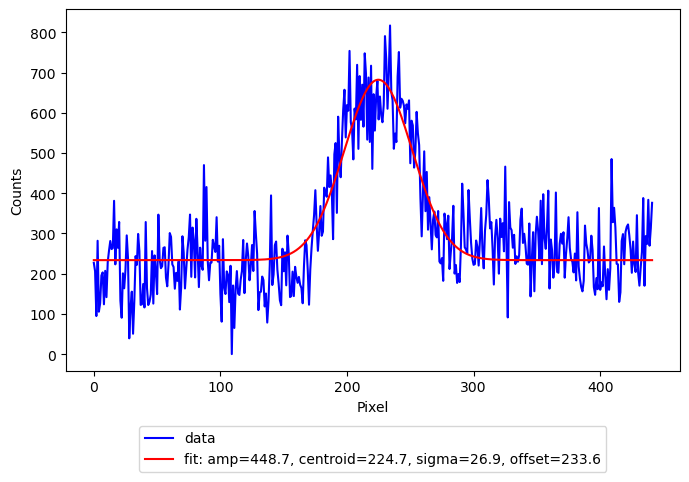

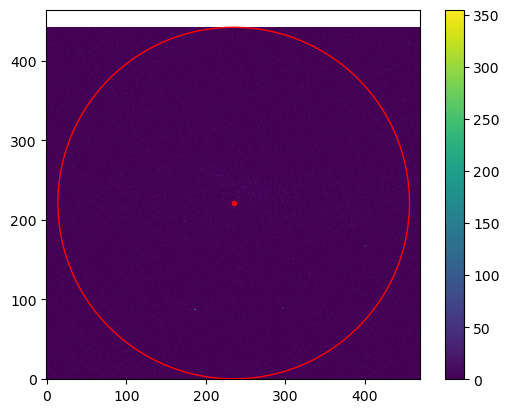

In [8]:
image_diagnostic.test_measurement()

In [9]:
import pandas as pd
filename = "../variables.csv"
VARIABLE_RANGES = pd.read_csv(filename, index_col=0, header=None).T.to_dict(orient='list')

In [10]:
# extend range for 'QUAD:IN20:425:BCTRL'
VARIABLE_RANGES['QUAD:IN20:425:BCTRL'] = [-1.0, 1.0]

In [11]:
# # replace w turbo ranges
# VARIABLE_RANGES = {"QUAD:IN20:121:BCTRL": [-0.010216134865221826, 0.0004946549130899012],
# "QUAD:IN20:122:BCTRL": [-0.0037497838633867926, 0.0046256696462631235],
# "QUAD:IN20:361:BCTRL": [-3.566282173921773, -2.952950549721718],
# "QUAD:IN20:371:BCTRL": [2.1990287090002765, 2.942573140353014],
# "QUAD:IN20:425:BCTRL": [-1.8677221410349012, -1.08],
# "QUAD:IN20:441:BCTRL": [-1.08, 0.3188352971091497],
# "QUAD:IN20:511:BCTRL": [2.5533611167764256, 4.642105910740238],
# "QUAD:IN20:525:BCTRL": [-4.004095742514585, -2.429185827568884],
# "SOLN:IN20:121:BCTRL": [0.4603330888274317, 0.4898202648048277]}

In [12]:
# replace w region around default
default = {
 'SOLN:IN20:121:BCTRL': 0.4755556,
 'QUAD:IN20:121:BCTRL': -5.4210109e-20,
 'QUAD:IN20:122:BCTRL': 0.0032420044,
 'QUAD:IN20:361:BCTRL': -3.1695391,
 'QUAD:IN20:371:BCTRL': 2.6302482,
 'QUAD:IN20:425:BCTRL': -0.3048029,
 'QUAD:IN20:441:BCTRL': -0.6233053,
 'QUAD:IN20:511:BCTRL': 4.2917846,
 'QUAD:IN20:525:BCTRL': -4.8686214
}

restricted_bounds = {
    k: [max(default[k] - 0.1 * (v[1] - v[0]), v[0]), min(default[k] + 0.1 * (v[1] - v[0]), v[1])]
    for k, v in VARIABLE_RANGES.items()
}
VARIABLE_RANGES = restricted_bounds

In [13]:
# adjust for NN bounds
# VARIABLE_RANGES["QUAD:IN20:121:BCTRL"][0] = -0.0027111474311571513
VARIABLE_RANGES["SOLN:IN20:121:BCTRL"][1] = 0.47478817375227245

In [14]:
VARIABLE_RANGES

{'SOLN:IN20:121:BCTRL': [0.4634556, 0.47478817375227245],
 'QUAD:IN20:121:BCTRL': [-0.004200000000000001, 0.004200000000000001],
 'QUAD:IN20:122:BCTRL': [-0.0009579956000000008, 0.0074420044000000005],
 'QUAD:IN20:361:BCTRL': [-3.4935391000000005, -2.8455391],
 'QUAD:IN20:371:BCTRL': [2.3082482, 2.9522482],
 'QUAD:IN20:425:BCTRL': [-0.5048029, -0.10480289999999998],
 'QUAD:IN20:441:BCTRL': [-1.08, 0.24069470000000015],
 'QUAD:IN20:511:BCTRL': [3.4277846, 5.1557846],
 'QUAD:IN20:525:BCTRL': [-5.5166214, -4.220621400000001]}

In [15]:
IMAGE_CONSTRAINTS = {
            "bb_penalty": ["LESS_THAN", 0.0],
            "log10_total_intensity": ["GREATER_THAN", image_diagnostic.min_log_intensity]
        }

from xopt import VOCS
VARIABLES = ["SOLN:IN20:121:BCTRL", "QUAD:IN20:121:BCTRL","QUAD:IN20:122:BCTRL",'QUAD:IN20:361:BCTRL','QUAD:IN20:371:BCTRL','QUAD:IN20:425:BCTRL','QUAD:IN20:441:BCTRL','QUAD:IN20:511:BCTRL','QUAD:IN20:525:BCTRL']
vocs = VOCS(
        variables = {ele: VARIABLE_RANGES[ele] for ele in VARIABLES},
        #constraints = IMAGE_CONSTRAINTS,
        objectives = {"total_size": "MINIMIZE"},
    )
print(vocs)

variables={'SOLN:IN20:121:BCTRL': [0.4634556, 0.47478817375227245], 'QUAD:IN20:121:BCTRL': [-0.004200000000000001, 0.004200000000000001], 'QUAD:IN20:122:BCTRL': [-0.0009579956000000008, 0.0074420044000000005], 'QUAD:IN20:361:BCTRL': [-3.4935391000000005, -2.8455391], 'QUAD:IN20:371:BCTRL': [2.3082482, 2.9522482], 'QUAD:IN20:425:BCTRL': [-0.5048029, -0.10480289999999998], 'QUAD:IN20:441:BCTRL': [-1.08, 0.24069470000000015], 'QUAD:IN20:511:BCTRL': [3.4277846, 5.1557846], 'QUAD:IN20:525:BCTRL': [-5.5166214, -4.220621400000001]} constraints={} objectives={'total_size': 'MINIMIZE'} constants={} observables=[]


In [16]:
from epics import caput, caget_many
from time import sleep
import numpy as np
def eval_beamsize(inputs):
    global image_diagnostic
    # set PVs
    for k, v in inputs.items():
        print(f'CAPUT {k} {v}')
        caput(k, v)

    sleep(2.0)

    # get beam sizes from image diagnostic
    metadata = inputs
    results = image_diagnostic.measure_beamsize(3, **metadata)
    results["S_x_mm"] = np.array(results["Sx"]) * 1e-3
    results["S_y_mm"] = np.array(results["Sy"]) * 1e-3

    # get other PV's NOTE: Measurements not synchronous with beamsize measurements!
    results = results

    # add total beam size
    results["total_size"] = np.sqrt(np.array(results["Sx"]) ** 2 + np.array(results["Sy"]) ** 2)
    # results["total_size"] = np.sqrt(np.abs(np.array(results["Sx"])) * np.array(results["Sy"]))
    return results

## Define NN prior

In [17]:
import torch

from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

In [18]:
model_path = "lcls_cu_injector_nn_model/"

# load nn_to_cal transformers
reg = "low"  # "low" or "high"
input_nn_to_cal = torch.load(f"calibration/input_nn_to_cal_{reg}_reg.pt")
output_nn_to_cal = torch.load(f"calibration/output_nn_to_cal_{reg}_reg.pt")

# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_path + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_path + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_path + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_path + "model/output_pv_to_sim.pt")

# load in- and output variable specification
# input_variables, output_variables = variables_from_yaml(open(model_path + "model/pv_variables.yml"))
input_variables, output_variables = variables_from_yaml(open(f"calibration/pv_variables_{reg}_reg.yml"))

# replace keys in input variables
input_variables = {name.replace("BACT", "BCTRL"): ele for name, ele in input_variables.items()}

# create LUME-model
lume_model = PyTorchModel(
    model_file=model_path + "model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    # input_transformers=[input_pv_to_sim, input_sim_to_nn],
    # output_transformers=[output_sim_to_nn, output_pv_to_sim],
    input_transformers=[input_pv_to_sim, input_sim_to_nn, input_nn_to_cal],
    output_transformers=[output_nn_to_cal, output_sim_to_nn, output_pv_to_sim],
)

# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=vocs.variable_names,
    output_order=lume_model.outputs[0:2],
)

# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2)

    def forward(self, x) -> torch.Tensor:
        res = torch.zeros(x.shape[:-1])
        #idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        #idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        #sigma_x = self.model(x)[..., idx_sigma_x]
        #sigma_y = self.model(x)[..., idx_sigma_y]
        #res = self.function(sigma_x, sigma_y)
        #print(x.shape)
        #print(res.shape)
        return res

objective_model = ObjectiveModel(lume_module)

print(lume_module.feature_order)
print(lume_module.output_order)

['QUAD:IN20:121:BCTRL', 'QUAD:IN20:122:BCTRL', 'QUAD:IN20:361:BCTRL', 'QUAD:IN20:371:BCTRL', 'QUAD:IN20:425:BCTRL', 'QUAD:IN20:441:BCTRL', 'QUAD:IN20:511:BCTRL', 'QUAD:IN20:525:BCTRL', 'SOLN:IN20:121:BCTRL']
['OTRS:IN20:571:XRMS', 'OTRS:IN20:571:YRMS']


In [19]:
for k, v in vocs.variables.items():
    if v[0] < input_variables[k].value_range[0]:
        print("lower_bound", k, v[0], input_variables[k].value_range[0])
    if v[1] > input_variables[k].value_range[1]:
        print("upper_bound", k, v[1], input_variables[k].value_range[1])

## Run Xopt

In [20]:
from gpytorch.means import ConstantMean

bb_penalty_prior = ConstantMean()
bb_penalty_prior.constant = 100.0
bb_penalty_prior.requires_grad_(False)
bb_penalty_prior.constant

Parameter containing:
tensor(100.)

In [21]:
from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import UpperConfidenceBoundGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor

# remember to set use low noise prior to false!!!
model_constructor = StandardModelConstructor(
    use_low_noise_prior=False,
    mean_modules={"total_size": objective_model},  # , "bb_penalty": bb_penalty_prior
)
generator = UpperConfidenceBoundGenerator(
    vocs=vocs,
    model_constructor=model_constructor,
    # turbo_controller="optimize",
)
generator.numerical_optimizer.max_iter = 200
evaluator = Evaluator(function=eval_beamsize)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.options.dump_file = run_dir + f"nn_optimization_cal_{reg}_reg_adj_bounds_1.yml"
X


            Xopt
________________________________
Version: 2.0a1+78.gd113821
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: true, dump_file: /home/physics3/ml_tuning/20230825_LCLS_Injector/nn_optimization_cal_low_reg_adj_bounds_1.yml,
  max_evaluations: null}
generator:
  name: upper_confidence_bound
  model: null
  turbo_controller: null
  use_cuda: false
  model_constructor:
    name: standard
    use_low_noise_prior: false
    covar_modules: {}
    mean_modules: {total_size: mean_modules_total_size.pt}
    trainable_mean_keys: []
  numerical_optimizer: {name: LBFGS, n_raw_samples: 20, n_restarts: 20, max_iter: 200}
  max_travel_distances: null
  fixed_features: null
  computation_time: {}
  n_candidates: 1
  n_monte_carlo_samples: 128
  beta: 2.0
evaluator:
  function: __main__.eval_beamsize
  max_workers: 1
  function_kwargs: {}
  vectorized: false
vocs:
  variables:
    SOLN:IN20:121:BCTRL: [0.4634556, 0.47478817375227245]
    QUAD:IN20:121:BCTRL: [-0.0042000000000000

In [22]:
import pandas as pd

default = {
 'SOLN:IN20:121:BCTRL': 0.4755556,
 'QUAD:IN20:121:BCTRL': -5.4210109e-20,
 'QUAD:IN20:122:BCTRL': 0.0032420044,
 'QUAD:IN20:361:BCTRL': -3.1695391,
 'QUAD:IN20:371:BCTRL': 2.6302482,
 'QUAD:IN20:425:BCTRL': -0.3048029,
 'QUAD:IN20:441:BCTRL': -0.6233053,
 'QUAD:IN20:511:BCTRL': 4.2917846,
 'QUAD:IN20:525:BCTRL': -4.8686214
}

custom_bounds = {k: [max(default[k] - 0.01 * (v[1] - v[0]), v[0]), min(default[k] + 0.01 * (v[1] - v[0]), v[1])]
                 for k, v in vocs.variables.items()}

X.random_evaluate(3, custom_bounds=custom_bounds)
# X.evaluate_data(pd.DataFrame(default, index=[0]))
#X.random_evaluate(20)

CAPUT QUAD:IN20:121:BCTRL 7.647949954024891e-05
CAPUT QUAD:IN20:122:BCTRL 0.003212172100690329
CAPUT QUAD:IN20:361:BCTRL -3.167177071198135
CAPUT QUAD:IN20:371:BCTRL 2.630061012540344
CAPUT QUAD:IN20:425:BCTRL -0.3029839501127123
CAPUT QUAD:IN20:441:BCTRL -0.6223876973936149
CAPUT QUAD:IN20:511:BCTRL 4.279552173058856
CAPUT QUAD:IN20:525:BCTRL -4.874019080002613
CAPUT SOLN:IN20:121:BCTRL 0.47478817375227245
CAPUT QUAD:IN20:121:BCTRL -6.296279040794423e-05
CAPUT QUAD:IN20:122:BCTRL 0.003208928230714892
CAPUT QUAD:IN20:361:BCTRL -3.1722670424476886
CAPUT QUAD:IN20:371:BCTRL 2.629820687072308
CAPUT QUAD:IN20:425:BCTRL -0.3014147700769852
CAPUT QUAD:IN20:441:BCTRL -0.6139778895861988
CAPUT QUAD:IN20:511:BCTRL 4.279466507089104
CAPUT QUAD:IN20:525:BCTRL -4.879674041907727
CAPUT SOLN:IN20:121:BCTRL 0.47478817375227245
CAPUT QUAD:IN20:121:BCTRL 7.923544543403244e-05
CAPUT QUAD:IN20:122:BCTRL 0.0032913512250999618
CAPUT QUAD:IN20:361:BCTRL -3.170982397422021
CAPUT QUAD:IN20:371:BCTRL 2.6262504

,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,SOLN:IN20:121:BCTRL,Cx,...,Sy,bb_penalty,total_intensity,log10_total_intensity,save_filename,S_x_mm,S_y_mm,total_size,xopt_runtime,xopt_error
1,0.000076,0.003212,-3.167177,2.630061,-0.302984,-0.622388,4.279552,-4.874019,0.474788,241.707082,...,124.77994,-156.170172,471584.0,5.673559,/home/physics3/ml_tuning/20230825_LCLS_Injecto...,0.080694,0.12478,148.598748,3.821036,False
1,0.000076,0.003212,-3.167177,2.630061,-0.302984,-0.622388,4.279552,-4.874019,0.474788,238.140265,...,119.87576,-164.604922,466481.4,5.668834,/home/physics3/ml_tuning/20230825_LCLS_Injecto...,0.069276,0.119876,138.453692,3.821036,False
1,0.000076,0.003212,-3.167177,2.630061,-0.302984,-0.622388,4.279552,-4.874019,0.474788,238.146108,...,110.10547,-166.149672,466481.4,5.668834,/home/physics3/ml_tuning/20230825_LCLS_Injecto...,0.071292,0.110105,131.171003,3.821036,False
2,-0.000063,0.003209,-3.172267,2.629821,-0.301415,-0.613978,4.279467,-4.879674,0.474788,241.236919,...,126.64763,-158.999908,470284.2,5.67236,/home/physics3/ml_tuning/20230825_LCLS_Injecto...,0.072655,0.126648,146.008155,3.941268,False
2,-0.000063,0.003209,-3.172267,2.629821,-0.301415,-0.613978,4.279467,-4.879674,0.474788,241.156663,...,125.731671,-159.330877,470284.2,5.67236,/home/physics3/ml_tuning/20230825_LCLS_Injecto...,0.071757,0.125732,144.766944,3.941268,False
2,-0.000063,0.003209,-3.172267,2.629821,-0.301415,-0.613978,4.279467,-4.879674,0.474788,240.318138,...,116.859965,-159.310552,465062.0,5.667511,/home/physics3/ml_tuning/20230825_LCLS_Injecto...,0.077204,0.11686,140.059723,3.941268,False
3,0.000079,0.003291,-3.170982,2.626250,-0.305389,-0.613510,4.304650,-4.869407,0.474788,240.707682,...,110.401584,-159.456352,467463.0,5.669747,/home/physics3/ml_tuning/20230825_LCLS_Injecto...,0.080702,0.110402,136.752537,3.600197,False
3,0.000079,0.003291,-3.170982,2.626250,-0.305389,-0.613510,4.304650,-4.869407,0.474788,240.72111,...,112.151749,-159.124079,467463.0,5.669747,/home/physics3/ml_tuning/20230825_LCLS_Injecto...,0.080525,0.112152,138.066355,3.600197,False
3,0.000079,0.003291,-3.170982,2.626250,-0.305389,-0.613510,4.304650,-4.869407,0.474788,242.002532,...,130.986038,-155.547287,470868.2,5.672899,/home/physics3/ml_tuning/20230825_LCLS_Injecto...,0.078007,0.130986,152.454708,3.600197,False


In [23]:
print(X.data["total_size"].values)

[148.59874763765342 138.45369167795172 131.17100264821133
 146.00815467512172 144.76694352656622 140.05972345568657
 136.75253730765965 138.06635488997873 152.4547084437315]


In [40]:
for i in range(10):
    print(i)
    X.step()

0
CAPUT QUAD:IN20:121:BCTRL -0.004200000000000001
CAPUT QUAD:IN20:122:BCTRL -0.0009579956000000008
CAPUT QUAD:IN20:361:BCTRL -2.8455391
CAPUT QUAD:IN20:371:BCTRL 2.9522482
CAPUT QUAD:IN20:425:BCTRL -0.10480289999999998
CAPUT QUAD:IN20:441:BCTRL -1.08
CAPUT QUAD:IN20:511:BCTRL 5.1557846
CAPUT QUAD:IN20:525:BCTRL -4.220621400000001
CAPUT SOLN:IN20:121:BCTRL 0.4634556
1
CAPUT QUAD:IN20:121:BCTRL -0.004200000000000001
CAPUT QUAD:IN20:122:BCTRL -0.0009579956000000008
CAPUT QUAD:IN20:361:BCTRL -3.4935391000000005
CAPUT QUAD:IN20:371:BCTRL 2.9522482
CAPUT QUAD:IN20:425:BCTRL -0.5048029
CAPUT QUAD:IN20:441:BCTRL -1.08
CAPUT QUAD:IN20:511:BCTRL 3.4277846
CAPUT QUAD:IN20:525:BCTRL -5.5166214
CAPUT SOLN:IN20:121:BCTRL 0.4634556
2
CAPUT QUAD:IN20:121:BCTRL -0.004200000000000001
CAPUT QUAD:IN20:122:BCTRL 0.0074420044000000005
CAPUT QUAD:IN20:361:BCTRL -3.4935391000000005
CAPUT QUAD:IN20:371:BCTRL 2.9522482
CAPUT QUAD:IN20:425:BCTRL -0.5048029
CAPUT QUAD:IN20:441:BCTRL 0.24069470000000015
CAPUT QUAD

In [41]:
X.data["total_size"].values

array([148.59874763765342, 138.45369167795172, 131.17100264821133,
       146.00815467512172, 144.76694352656622, 140.05972345568657,
       136.75253730765965, 138.06635488997873, 152.4547084437315, nan,
       nan, nan, 300.8955704457896, 326.3187474591668, 326.3246759223383,
       nan, nan, nan, 453.5835895727871, nan, 380.6234100287854, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       282.0974959845693, 335.6063564171587, 335.63746646866224,
       312.1027974286362, nan, nan, 311.2159723376363, 311.1260946391963,
       273.4071572262084, 236.69584077375532, 236.80689965588527,
       234.18106155692607, nan, nan, nan, nan, nan, nan,
       262.09326620797844, 262.1210107635901, 262.1176624955891,
       442.8664550593958, 439.7326473370504, 439.7296593695362,
       229.3086894968821, 228.2436203301663, 249.2131705208313, nan, nan,
       182.26080953177444, nan, nan, nan, 

<Axes: >

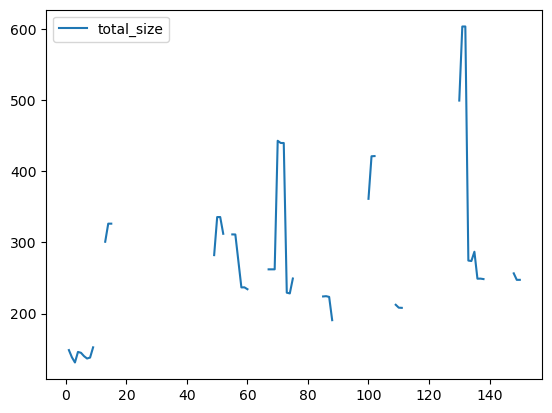

In [42]:
X.data.plot(y="total_size")

<Axes: >

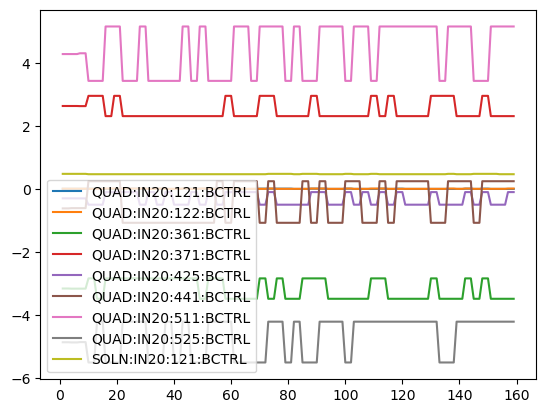

In [43]:
X.data.plot(y=X.vocs.variable_names)

In [30]:
X.data.head()["total_size"].mean()

140.85358386963424

In [31]:
X.data.tail()["total_size"].mean()

313.71605959247074

In [32]:
X.data["total_size"].min()

96.63685778562963

In [44]:
X.data["bb_penalty"].values

array([-157.40610360760462, -158.68850928651017, -158.83389378654357,
       -158.78779512027245, -160.08874771558942, -159.04851393217746,
       -158.4301134173072, -158.8129698740294, -156.40166571394718,
       -95.33421514323274, -73.77362128087779, -73.79509809262944,
       -142.65852540474592, -143.2586055264362, -145.7880981046548,
       -149.38598450244424, -149.1074857875988, -148.5904622750869,
       -146.00445129532906, -151.72745460712952, -151.3473180282424,
       -150.10957276779325, -150.12719865609324, -155.9280798849825,
       -150.11530105489658, -148.431834801182, -147.98759837266812, nan,
       -151.32601097617402, -150.66295293252188, -149.20103067952664,
       -153.67567021087916, -151.68941519786813, -138.52897414221223,
       -138.46064721850468, -137.97126654726011, -163.5416472830336,
       -163.5176058749563, -162.32077533842528, -155.46289063368982,
       -155.44121246654845, -156.78083086626106, -158.95552926835614,
       -160.0324407076588, -15

In [45]:
X.data.iloc[-1]

QUAD:IN20:121:BCTRL                                              -0.000693
QUAD:IN20:122:BCTRL                                               0.000658
QUAD:IN20:361:BCTRL                                              -3.011571
QUAD:IN20:371:BCTRL                                               2.495699
QUAD:IN20:425:BCTRL                                              -0.230673
QUAD:IN20:441:BCTRL                                              -0.525908
QUAD:IN20:511:BCTRL                                               3.677753
QUAD:IN20:525:BCTRL                                              -4.220621
SOLN:IN20:121:BCTRL                                               0.474512
Cx                                                                     NaN
Cy                                                                     NaN
Sx                                                                     NaN
Sy                                                                     NaN
bb_penalty               

In [42]:
from scripts.utils.read_files import read_file
res = read_file(X.data.iloc[-4]["save_filename"])

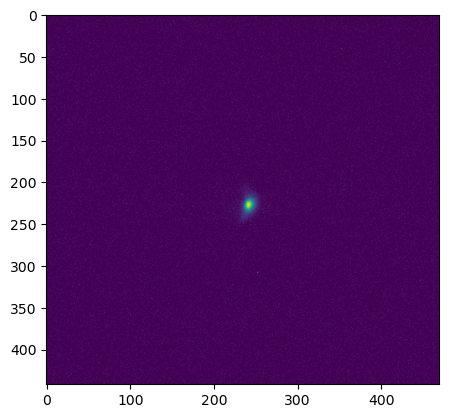

In [43]:
plt.imshow(res["images"][0])

In [34]:
res

{'images': array([[[ 1.2,  0. ,  3.8, ...,  0. ,  5.2,  7.2],
         [13.4,  3.8,  0. , ...,  0. ,  0. ,  2.6],
         [ 0. ,  2.2,  0. , ...,  0. ,  0. ,  0. ],
         ...,
         [11. ,  5. ,  0. , ...,  0. ,  0. ,  0. ],
         [ 2.2,  0. ,  0. , ...,  0. ,  0. ,  0. ],
         [ 0. ,  0. ,  0. , ...,  0. ,  2.8,  0. ]],
 
        [[ 0.2,  0. ,  4.8, ...,  2.4,  2.2,  8.2],
         [ 6.4,  6.8,  0. , ...,  0. ,  2.2,  0. ],
         [ 0. ,  2.2,  0. , ...,  0. ,  0. ,  0. ],
         ...,
         [ 7. ,  0. ,  0. , ...,  0. ,  2.8,  0. ],
         [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  1. ],
         [ 0. ,  0. ,  0. , ...,  0. ,  2.8,  0. ]],
 
        [[ 0.2,  0. ,  4.8, ...,  2.4,  2.2,  8.2],
         [ 6.4,  6.8,  0. , ...,  0. ,  2.2,  0. ],
         [ 0. ,  2.2,  0. , ...,  0. ,  0. ,  0. ],
         ...,
         [ 7. ,  0. ,  0. , ...,  0. ,  2.8,  0. ],
         [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  1. ],
         [ 0. ,  0. ,  0. , ...,  0. ,  2.8,  0. ]]]),
 'C

In [35]:
X.generator.computation_time

,training,acquisition_optimization
0,0.087508,0.955635
1,0.132266,1.014755
2,0.286620,0.955529
3,0.205184,0.971701
4,0.122552,0.985554
5,0.133408,1.007416
6,0.235486,1.053104
7,0.234884,1.042659
8,0.238851,1.022240
9,0.203422,1.057713
